# Table of Contents
### 0. Setup
### 1. Data Loading, EDA, and Preprocessing
   - 1.1 Data Loading
   - 1.2 Exploratory Data Analysis (EDA)
   - 1.3 Missing Values
   - 1.4 Duplicates
   - 1.5 Feature Selection
   - 1.6 Correlations
   - 1.7 Skewness
   - 1.8 Outliers

### 2. Deep Learning
   - 2.1 SciKit-Learn MLP Classifier
   - 2.2 Keras Classifier
     - 2.2.1 Model Evaluation
     - 2.2.2 Hyperparameter Tuning

## 0. Setup

Installing the required libraries.

In [35]:
pip install pyarrow handyspark tensorflow keras

Import the required libraries.

In [1]:
# Data manipulation and visualization
import pandas as pd  # for data manipulation
import numpy as np  # for numerical computations
import matplotlib.pyplot as plt  # for data visualization
import seaborn as sns  # for data visualization

# Spark related imports
from pyspark.sql import DataFrameStatFunctions, SparkSession  # for distributed computing
from pyspark.sql.functions import col # for column operations in PySpark
from handyspark import *  # for enhanced Spark functionality

# TensorFlow and Keras for deep learning
import tensorflow as tf  # for deep learning framework
import tensorflow.keras  # for building neural networks
from tensorflow.keras.models import Sequential  # Sequential model for stacking layers
from tensorflow.keras.layers import Dense, Dropout  # Dense for fully connected layers, Dropout for regularization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # optimizers for training the model
from tensorflow.keras.callbacks import EarlyStopping  # for stopping training early
from tensorflow.keras import regularizers  # for applying penalties on layer parameters
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier  # for using Keras models in scikit-learn

# Scikit-learn for machine learning utilities
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV  # utilities for cross-validation and hyperparameter tuning
from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn import metrics  # for evaluating model performance
from sklearn.neural_network import MLPClassifier  # for neural network-based classification
from sklearn.model_selection import learning_curve  # for plotting learning curves

# Suppressing warnings and unnecessary logs
import warnings
warnings.filterwarnings("ignore")

# Suppress WARN messages
import logging
log = logging.getLogger('py4j')
log.setLevel(logging.ERROR)

## 1. Data loading, EDA, Data Visualization and Preprocessing

<a class="anchor" id="1.1"></a>
### 1.1 Data loading

In [2]:
# Check the address of the Spark Master
sc.master

'local[*]'

Creating the Spark Session and loading file from Hadoop

In [3]:
# Create a SparkSession
spark = (SparkSession.builder
    .appName("Read CSV from Hadoop")
    .config("spark.driver.memory", "8G") # Increase memory for the driver
    .config("spark.executor.memory", "8G") # Increase memory for executors
    .config("spark.master", "local[4]") # Use 4 cores for both driver and executor for parallel processing
    .getOrCreate())

# Specify the Hadoop file path
hadoop_file_path = "hdfs://localhost:9000/result.csv"

# Read the CSV file into a Spark DataFrame
df_toptag = spark.read.csv(hadoop_file_path, header=True, inferSchema=True)

24/04/06 23:00:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<a class="anchor" id="1.2"></a>
### 1.2 EDA

In [6]:
# Checking the file the schema
df_toptag.printSchema()

root
 |-- fjet_C2: double (nullable = true)
 |-- fjet_D2: double (nullable = true)
 |-- fjet_ECF1: double (nullable = true)
 |-- fjet_ECF2: double (nullable = true)
 |-- fjet_ECF3: double (nullable = true)
 |-- fjet_L2: double (nullable = true)
 |-- fjet_L3: double (nullable = true)
 |-- fjet_Qw: double (nullable = true)
 |-- fjet_Split12: double (nullable = true)
 |-- fjet_Split23: double (nullable = true)
 |-- fjet_Tau1_wta: double (nullable = true)
 |-- fjet_Tau2_wta: double (nullable = true)
 |-- fjet_Tau3_wta: double (nullable = true)
 |-- fjet_Tau4_wta: double (nullable = true)
 |-- fjet_ThrustMaj: double (nullable = true)
 |-- fjet_eta: double (nullable = true)
 |-- fjet_m: double (nullable = true)
 |-- fjet_phi: double (nullable = true)
 |-- fjet_pt: double (nullable = true)
 |-- labels: double (nullable = true)
 |-- weights: double (nullable = true)
 |-- fjet_clus_E_0: double (nullable = true)
 |-- fjet_clus_E_1: double (nullable = true)
 |-- fjet_clus_E_2: double (nullable = 

The schema of the Spark DataFrame visually matches the schema of the original CSV file, which may indicate successful reading of the CSV file from Hadoop and its conversion into a Spark DataFrame.

The data set contains the following information:
- The four vectors of constituent particles (columns: ```fjet_eta, fjet_m, fjet_phi, fjet_pt```)
- 15 high level summary quantities evaluated on the jet (columns: ```fjet_C2, fjet_D2, fjet_ECF1, fjet_ECF2, fjet_ECF3, fjet_L2, fjet_L3, fjet_Qw, fjet_Split12, fjet_Split23, fjet_Tau1_wta, fjet_Tau2_wta, fjet_Tau3_wta, fjet_Tau4_wta, fjet_ThrustMaj```)
- The four vector of the whole jet, containing 200 observations each (columns: ```fjet_clus_E, fjet_clus_eta, fjet_clus_phi, fjet_clus_pt```) 
- A training weight (column ```weights```) 
- A signal (1) vs background (0) label (column ```labels```)

In [5]:
# Checking shape of the dataset
print('Shape of the dataset:', df_toptag.count(), len(df_toptag.columns))

Shape of the dataset: 2484117 821


The shape of the Spark DataFrame also matches the shape of the original CSV file.

The DataFrame contains approximately 2.5 million observations distributed across 821 columns.

In [6]:
# Checking first 5 rows
df_toptag.show(5)

24/04/02 17:18:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+------------------+-----------+----------------+--------------------+-------------------+-------------------+---------------+---------------+----------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------+-------------------+-----------+------+-------------------+-------------+-------------+-------------+--------------+--------------+--------------+---------------+---------------+--------------+---------------+---------------+----------------+----------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------

Displaying 5 rows horizontally is not really informative due to the large number of features. Instead, showing the first 5 rows in a vertical format could improve understanding.

In [7]:
# Display the first 5 rows of the DataFrame in a vertical format
df_toptag.show(5, vertical=True)

-RECORD 0---------------------------------
 fjet_C2           | 0.11578615754842758  
 fjet_D2           | 1.8744012117385864   
 fjet_ECF1         | 1117379.875          
 fjet_ECF2         | 7.7125107712E10      
 fjet_ECF3         | 6.16378339950592E14  
 fjet_L2           | 0.2844608426094055   
 fjet_L3           | 0.0955781415104866   
 fjet_Qw           | 58778.8359375        
 fjet_Split12      | 33904.11328125       
 fjet_Split23      | 32111.3046875        
 fjet_Tau1_wta     | 0.07820309698581696  
 fjet_Tau2_wta     | 0.058272846043109894 
 fjet_Tau3_wta     | 0.03688522428274155  
 fjet_Tau4_wta     | 0.02544139139354229  
 fjet_ThrustMaj    | 0.8938071131706238   
 fjet_eta          | 1.0349453687667847   
 fjet_m            | 156478.15625         
 fjet_phi          | 1.5640913248062134   
 fjet_pt           | 1275630.125          
 labels            | 0.0                  
 weights           | 0.8066954016685486   
 fjet_clus_E_0     | 391182.96875         
 fjet_clus_

Reviewing the descriptive statistics - presented in a vertical format.

In [8]:
# Calculate descriptive statistics and display it in a vertical format
df_toptag.describe().show(vertical=True)

24/04/02 17:19:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/04/02 17:31:56 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


-RECORD 0---------------------------------
 summary           | count                
 fjet_C2           | 2484117              
 fjet_D2           | 2484117              
 fjet_ECF1         | 2484117              
 fjet_ECF2         | 2484117              
 fjet_ECF3         | 2484117              
 fjet_L2           | 2484117              
 fjet_L3           | 2484117              
 fjet_Qw           | 2484117              
 fjet_Split12      | 2484117              
 fjet_Split23      | 2484117              
 fjet_Tau1_wta     | 2484117              
 fjet_Tau2_wta     | 2484117              
 fjet_Tau3_wta     | 2484117              
 fjet_Tau4_wta     | 2484117              
 fjet_ThrustMaj    | 2484117              
 fjet_eta          | 2484117              
 fjet_m            | 2484117              
 fjet_phi          | 2484117              
 fjet_pt           | 2484117              
 labels            | 2484117              
 weights           | 2484117              
 fjet_clus_

To improve readability, the output can be converted into a more convenient format by transforming it into a pandas DataFrame.

In [9]:
# Set pandas option to display unlimited columns and rows without truncation
pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.max_rows', None) # Display all rows

# Calculate descriptive statistics and convert the result to a pandas DataFrame
df_toptag_descr = df_toptag.describe().toPandas()
# Display the resulting pandas DataFrame
df_toptag_descr

24/04/02 17:32:29 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/04/02 17:45:41 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


,summary,fjet_C2,fjet_D2,fjet_ECF1,fjet_ECF2,fjet_ECF3,fjet_L2,fjet_L3,fjet_Qw,fjet_Split12,fjet_Split23,fjet_Tau1_wta,fjet_Tau2_wta,fjet_Tau3_wta,fjet_Tau4_wta,fjet_ThrustMaj,fjet_eta,fjet_m,fjet_phi,fjet_pt,labels,weights,fjet_clus_E_0,fjet_clus_E_1,fjet_clus_E_2,fjet_clus_E_3,fjet_clus_E_4,fjet_clus_E_5,fjet_clus_E_6,fjet_clus_E_7,fjet_clus_E_8,fjet_clus_E_9,fjet_clus_E_10,fjet_clus_E_11,fjet_clus_E_12,fjet_clus_E_13,fjet_clus_E_14,fjet_clus_E_15,fjet_clus_E_16,fjet_clus_E_17,fjet_clus_E_18,fjet_clus_E_19,fjet_clus_E_20,fjet_clus_E_21,fjet_clus_E_22,fjet_clus_E_23,fjet_clus_E_24,fjet_clus_E_25,fjet_clus_E_26,fjet_clus_E_27,fjet_clus_E_28,fjet_clus_E_29,fjet_clus_E_30,fjet_clus_E_31,fjet_clus_E_32,fjet_clus_E_33,fjet_clus_E_34,fjet_clus_E_35,fjet_clus_E_36,fjet_clus_E_37,fjet_clus_E_38,fjet_clus_E_39,fjet_clus_E_40,fjet_clus_E_41,fjet_clus_E_42,fjet_clus_E_43,fjet_clus_E_44,fjet_clus_E_45,fjet_clus_E_46,fjet_clus_E_47,fjet_clus_E_48,fjet_clus_E_49,fjet_clus_E_50,fjet_clus_E_51,fjet_clus_E_52,fjet_clus_E_53,fjet_clus_E_54,fjet_clus_E_55,fjet_clus_E_56,fjet_clus_E_57,fjet_clus_E_58,fjet_clus_E_59,fjet_clus_E_60,fjet_clus_E_61,fjet_clus_E_62,fjet_clus_E_63,fjet_clus_E_64,fjet_clus_E_65,fjet_clus_E_66,fjet_clus_E_67,fjet_clus_E_68,fjet_clus_E_69,fjet_clus_E_70,fjet_clus_E_71,fjet_clus_E_72,fjet_clus_E_73,fjet_clus_E_74,fjet_clus_E_75,fjet_clus_E_76,fjet_clus_E_77,fjet_clus_E_78,fjet_clus_E_79,fjet_clus_E_80,fjet_clus_E_81,fjet_clus_E_82,fjet_clus_E_83,fjet_clus_E_84,fjet_clus_E_85,fjet_clus_E_86,fjet_clus_E_87,fjet_clus_E_88,fjet_clus_E_89,fjet_clus_E_90,fjet_clus_E_91,fjet_clus_E_92,fjet_clus_E_93,fjet_clus_E_94,fjet_clus_E_95,fjet_clus_E_96,fjet_clus_E_97,fjet_clus_E_98,fjet_clus_E_99,fjet_clus_E_100,fjet_clus_E_101,fjet_clus_E_102,fjet_clus_E_103,fjet_clus_E_104,fjet_clus_E_105,fjet_clus_E_106,fjet_clus_E_107,fjet_clus_E_108,fjet_clus_E_109,fjet_clus_E_110,fjet_clus_E_111,fjet_clus_E_112,fjet_clus_E_113,fjet_clus_E_114,fjet_clus_E_115,fjet_clus_E_116,fjet_clus_E_117,fjet_clus_E_118,fjet_clus_E_119,fjet_clus_E_120,fjet_clus_E_121,fjet_clus_E_122,fjet_clus_E_123,fjet_clus_E_124,fjet_clus_E_125,fjet_clus_E_126,fjet_clus_E_127,fjet_clus_E_128,fjet_clus_E_129,fjet_clus_E_130,fjet_clus_E_131,fjet_clus_E_132,fjet_clus_E_133,fjet_clus_E_134,fjet_clus_E_135,fjet_clus_E_136,fjet_clus_E_137,fjet_clus_E_138,fjet_clus_E_139,fjet_clus_E_140,fjet_clus_E_141,fjet_clus_E_142,fjet_clus_E_143,fjet_clus_E_144,fjet_clus_E_145,fjet_clus_E_146,fjet_clus_E_147,fjet_clus_E_148,fjet_clus_E_149,fjet_clus_E_150,fjet_clus_E_151,fjet_clus_E_152,fjet_clus_E_153,fjet_clus_E_154,fjet_clus_E_155,fjet_clus_E_156,fjet_clus_E_157,fjet_clus_E_158,fjet_clus_E_159,fjet_clus_E_160,fjet_clus_E_161,fjet_clus_E_162,fjet_clus_E_163,fjet_clus_E_164,fjet_clus_E_165,fjet_clus_E_166,fjet_clus_E_167,fjet_clus_E_168,fjet_clus_E_169,fjet_clus_E_170,fjet_clus_E_171,fjet_clus_E_172,fjet_clus_E_173,fjet_clus_E_174,fjet_clus_E_175,fjet_clus_E_176,fjet_clus_E_177,fjet_clus_E_178,fjet_clus_E_179,fjet_clus_E_180,fjet_clus_E_181,fjet_clus_E_182,fjet_clus_E_183,fjet_clus_E_184,fjet_clus_E_185,fjet_clus_E_186,fjet_clus_E_187,fjet_clus_E_188,fjet_clus_E_189,fjet_clus_E_190,fjet_clus_E_191,fjet_clus_E_192,fjet_clus_E_193,fjet_clus_E_194,fjet_clus_E_195,fjet_clus_E_196,fjet_clus_E_197,fjet_clus_E_198,fjet_clus_E_199,fjet_clus_eta_0,fjet_clus_eta_1,fjet_clus_eta_2,fjet_clus_eta_3,fjet_clus_eta_4,fjet_clus_eta_5,fjet_clus_eta_6,fjet_clus_eta_7,fjet_clus_eta_8,fjet_clus_eta_9,fjet_clus_eta_10,fjet_clus_eta_11,fjet_clus_eta_12,fjet_clus_eta_13,fjet_clus_eta_14,fjet_clus_eta_15,fjet_clus_eta_16,fjet_clus_eta_17,fjet_clus_eta_18,fjet_clus_eta_19,fjet_clus_eta_20,fjet_clus_eta_21,fjet_clus_eta_22,fjet_clus_eta_23,fjet_clus_eta_24,fjet_clus_eta_25,fjet_clus_eta_26,fjet_clus_eta_27,fjet_clus_eta_28,fjet_clus_eta_29,fjet_clus_eta_30,fjet_clus_eta_31,fjet_clus_eta_32,fjet_clus_eta_33,fjet_clus_eta_34,fjet_clus_eta_35,fjet_clus_eta_36,fjet_clus_eta_37,fjet_clus_eta_38,fjet_clus_eta_39,fjet_clus_eta_40

Based on the descriptive statistics it is possible to conclude the following:
- All columns have 2484177 observations.
- The column ```labels``` contain binary labels.
- Some of the columns, such as ```fjet_ECF2``` and ```fjet_ECF3```, have very high values and a huge range of values, likely indicating the presence of outliers or extreme data points.
- Features such as ```fjet_C2, fjet_D2```, and ```fjet_L2``` have low means and standard deviations, suggesting that they are concentrated in a narrow range.

Checking proportion of labels.
Grouping by 'labels', count the occurrences.

In [12]:
# Grouping by the 'labels' column and counting the occurrences of each label
label_counts = df_toptag.groupby('labels').count()

# Displaying the resulting counts
label_counts.show()

+------+-------+
|labels|  count|
+------+-------+
|   0.0|1242975|
|   1.0|1241142|
+------+-------+



Roughly equal numbers of labels for each class indicate a balanced distribution of data.

<a class="anchor" id="1.3"></a>
###  1.3 Missing values

Checking the data on missing values.

In [30]:
# Check for null, None, empty strings, or NaN values in each column
null_df = df_toptag.select([count(when(col(c).contains('NULL') | \
                                       col(c).contains('None') | \
                                       (col(c) =='') | \
                                       col(c).isNull() | \
                                       isnan(c), c
                                      )).alias(c)
                           for c in df_toptag.columns])

# Convert the PySpark DataFrame to a Pandas DataFrame for simplier visibility
null_df_pd = null_df.toPandas()
# Add a new column to calculate the total count of null-like values across all columns
null_df_pd.insert(0, 'Total Nulls', null_df_pd.sum(axis=1))

# Display the results
null_df_pd

24/04/02 21:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1199.0 KiB
24/04/02 21:27:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


,Total Nulls,fjet_C2,fjet_D2,fjet_ECF1,fjet_ECF2,fjet_ECF3,fjet_L2,fjet_L3,fjet_Qw,fjet_Split12,fjet_Split23,fjet_Tau1_wta,fjet_Tau2_wta,fjet_Tau3_wta,fjet_Tau4_wta,fjet_ThrustMaj,fjet_eta,fjet_m,fjet_phi,fjet_pt,labels,weights,fjet_clus_E_0,fjet_clus_E_1,fjet_clus_E_2,fjet_clus_E_3,fjet_clus_E_4,fjet_clus_E_5,fjet_clus_E_6,fjet_clus_E_7,fjet_clus_E_8,fjet_clus_E_9,fjet_clus_E_10,fjet_clus_E_11,fjet_clus_E_12,fjet_clus_E_13,fjet_clus_E_14,fjet_clus_E_15,fjet_clus_E_16,fjet_clus_E_17,fjet_clus_E_18,fjet_clus_E_19,fjet_clus_E_20,fjet_clus_E_21,fjet_clus_E_22,fjet_clus_E_23,fjet_clus_E_24,fjet_clus_E_25,fjet_clus_E_26,fjet_clus_E_27,fjet_clus_E_28,fjet_clus_E_29,fjet_clus_E_30,fjet_clus_E_31,fjet_clus_E_32,fjet_clus_E_33,fjet_clus_E_34,fjet_clus_E_35,fjet_clus_E_36,fjet_clus_E_37,fjet_clus_E_38,fjet_clus_E_39,fjet_clus_E_40,fjet_clus_E_41,fjet_clus_E_42,fjet_clus_E_43,fjet_clus_E_44,fjet_clus_E_45,fjet_clus_E_46,fjet_clus_E_47,fjet_clus_E_48,fjet_clus_E_49,fjet_clus_E_50,fjet_clus_E_51,fjet_clus_E_52,fjet_clus_E_53,fjet_clus_E_54,fjet_clus_E_55,fjet_clus_E_56,fjet_clus_E_57,fjet_clus_E_58,fjet_clus_E_59,fjet_clus_E_60,fjet_clus_E_61,fjet_clus_E_62,fjet_clus_E_63,fjet_clus_E_64,fjet_clus_E_65,fjet_clus_E_66,fjet_clus_E_67,fjet_clus_E_68,fjet_clus_E_69,fjet_clus_E_70,fjet_clus_E_71,fjet_clus_E_72,fjet_clus_E_73,fjet_clus_E_74,fjet_clus_E_75,fjet_clus_E_76,fjet_clus_E_77,fjet_clus_E_78,fjet_clus_E_79,fjet_clus_E_80,fjet_clus_E_81,fjet_clus_E_82,fjet_clus_E_83,fjet_clus_E_84,fjet_clus_E_85,fjet_clus_E_86,fjet_clus_E_87,fjet_clus_E_88,fjet_clus_E_89,fjet_clus_E_90,fjet_clus_E_91,fjet_clus_E_92,fjet_clus_E_93,fjet_clus_E_94,fjet_clus_E_95,fjet_clus_E_96,fjet_clus_E_97,fjet_clus_E_98,fjet_clus_E_99,fjet_clus_E_100,fjet_clus_E_101,fjet_clus_E_102,fjet_clus_E_103,fjet_clus_E_104,fjet_clus_E_105,fjet_clus_E_106,fjet_clus_E_107,fjet_clus_E_108,fjet_clus_E_109,fjet_clus_E_110,fjet_clus_E_111,fjet_clus_E_112,fjet_clus_E_113,fjet_clus_E_114,fjet_clus_E_115,fjet_clus_E_116,fjet_clus_E_117,fjet_clus_E_118,fjet_clus_E_119,fjet_clus_E_120,fjet_clus_E_121,fjet_clus_E_122,fjet_clus_E_123,fjet_clus_E_124,fjet_clus_E_125,fjet_clus_E_126,fjet_clus_E_127,fjet_clus_E_128,fjet_clus_E_129,fjet_clus_E_130,fjet_clus_E_131,fjet_clus_E_132,fjet_clus_E_133,fjet_clus_E_134,fjet_clus_E_135,fjet_clus_E_136,fjet_clus_E_137,fjet_clus_E_138,fjet_clus_E_139,fjet_clus_E_140,fjet_clus_E_141,fjet_clus_E_142,fjet_clus_E_143,fjet_clus_E_144,fjet_clus_E_145,fjet_clus_E_146,fjet_clus_E_147,fjet_clus_E_148,fjet_clus_E_149,fjet_clus_E_150,fjet_clus_E_151,fjet_clus_E_152,fjet_clus_E_153,fjet_clus_E_154,fjet_clus_E_155,fjet_clus_E_156,fjet_clus_E_157,fjet_clus_E_158,fjet_clus_E_159,fjet_clus_E_160,fjet_clus_E_161,fjet_clus_E_162,fjet_clus_E_163,fjet_clus_E_164,fjet_clus_E_165,fjet_clus_E_166,fjet_clus_E_167,fjet_clus_E_168,fjet_clus_E_169,fjet_clus_E_170,fjet_clus_E_171,fjet_clus_E_172,fjet_clus_E_173,fjet_clus_E_174,fjet_clus_E_175,fjet_clus_E_176,fjet_clus_E_177,fjet_clus_E_178,fjet_clus_E_179,fjet_clus_E_180,fjet_clus_E_181,fjet_clus_E_182,fjet_clus_E_183,fjet_clus_E_184,fjet_clus_E_185,fjet_clus_E_186,fjet_clus_E_187,fjet_clus_E_188,fjet_clus_E_189,fjet_clus_E_190,fjet_clus_E_191,fjet_clus_E_192,fjet_clus_E_193,fjet_clus_E_194,fjet_clus_E_195,fjet_clus_E_196,fjet_clus_E_197,fjet_clus_E_198,fjet_clus_E_199,fjet_clus_eta_0,fjet_clus_eta_1,fjet_clus_eta_2,fjet_clus_eta_3,fjet_clus_eta_4,fjet_clus_eta_5,fjet_clus_eta_6,fjet_clus_eta_7,fjet_clus_eta_8,fjet_clus_eta_9,fjet_clus_eta_10,fjet_clus_eta_11,fjet_clus_eta_12,fjet_clus_eta_13,fjet_clus_eta_14,fjet_clus_eta_15,fjet_clus_eta_16,fjet_clus_eta_17,fjet_clus_eta_18,fjet_clus_eta_19,fjet_clus_eta_20,fjet_clus_eta_21,fjet_clus_eta_22,fjet_clus_eta_23,fjet_clus_eta_24,fjet_clus_eta_25,fjet_clus_eta_26,fjet_clus_eta_27,fjet_clus_eta_28,fjet_clus_eta_29,fjet_clus_eta_30,fjet_clus_eta_31,fjet_clus_eta_32,fjet_clus_eta_33,fjet_clus_eta_34,fjet_clus_eta_35,fjet_clus_eta_36,fjet_clus_eta_37,fjet_clus_eta_38,fjet_clus_eta_39,fjet_clus_et

As observed, there are no missing values in the DataFrame.

<a class="anchor" id="1.4"></a>
###  1.4 Duplicates

Checking the data on duplicates.

In [3]:
# Count the number of rows before dropping duplicates
count_before = df_toptag.count()

# Drop duplicates
df_no_duplicates = df_toptag.dropDuplicates()

# Count the number of rows after dropping duplicates
count_after = df_no_duplicates.count()

# Calculate the number of duplicate rows
num_duplicates = count_before - count_after

# Check if there were any duplicates
if count_before != count_after:
    print("Duplicates were found. Number of rows with duplicates:", num_duplicates)
else:
    print("No duplicates were found.")

24/04/03 17:27:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


No duplicates were found.


<a class="anchor" id="1.5"></a>
### 1.5 Feature selection

For feature selection, I decided not to include data from columns containing information about the four vector of the whole jet (columns: ```fjet_clus_E, fjet_clus_eta, fjet_clus_phi, fjet_clus_pt```) due to limitations in computational resources. Additionally, I chose not to include the ```weights``` column in order to treat the data as 'fresh' and avoid the influence of previously fitted weights. My aim is to develop a neural network based on these 'clean' data and assess the outcomes of such research.

In [4]:
# Selecting specific columns from the original DataFrame to create a filtered DataFrame
df_filtered = df_toptag.select(
    "fjet_C2", "fjet_D2", "fjet_ECF1", "fjet_ECF2", "fjet_ECF3",
    "fjet_L2", "fjet_L3", "fjet_Qw", "fjet_Split12", "fjet_Split23",
    "fjet_Tau1_wta", "fjet_Tau2_wta", "fjet_Tau3_wta", "fjet_Tau4_wta",
    "fjet_ThrustMaj", "fjet_eta", "fjet_m", "fjet_phi", "fjet_pt", "labels"
)

# Show the schemas of the resulting DataFrame
print("Schema for filtered dataset:")
df_filtered.printSchema()

Schema for filtered dataset:
root
 |-- fjet_C2: double (nullable = true)
 |-- fjet_D2: double (nullable = true)
 |-- fjet_ECF1: double (nullable = true)
 |-- fjet_ECF2: double (nullable = true)
 |-- fjet_ECF3: double (nullable = true)
 |-- fjet_L2: double (nullable = true)
 |-- fjet_L3: double (nullable = true)
 |-- fjet_Qw: double (nullable = true)
 |-- fjet_Split12: double (nullable = true)
 |-- fjet_Split23: double (nullable = true)
 |-- fjet_Tau1_wta: double (nullable = true)
 |-- fjet_Tau2_wta: double (nullable = true)
 |-- fjet_Tau3_wta: double (nullable = true)
 |-- fjet_Tau4_wta: double (nullable = true)
 |-- fjet_ThrustMaj: double (nullable = true)
 |-- fjet_eta: double (nullable = true)
 |-- fjet_m: double (nullable = true)
 |-- fjet_phi: double (nullable = true)
 |-- fjet_pt: double (nullable = true)
 |-- labels: double (nullable = true)



Additionally, I convert the PySpark DataFrame to HandySpark because HandySpark offers a user-friendly API, visualization capabilities, additional functionalities, and seamless integration with existing Spark code, simplifying data analysis tasks.

In [5]:
# Convert Spark DataFrame to HandySpark DataFrame
handy_df_filtered = df_filtered.toHandy()

<a class="anchor" id="1.6"></a>
### 1.6 Correlations

Let's examine the feature correlations by constructing a correlation heatmap.

In [45]:
# Functions for creating correlation heatmap for dataset
def plot_correlation_heatmap(dataset):
    # Convert the features into a single vector column
    assembler = VectorAssembler(inputCols=dataset.columns[1:], outputCol="features")
    df_assembled = assembler.transform(dataset).select("features")

    # Compute the correlation matrix
    correlation = Correlation.corr(df_assembled, "features").head()
    corr_matrix = correlation[0].toArray()

    # Set the figure size
    plt.figure(figsize=(12, 10))

    # Create the heatmap with Seaborn using 'viridis' colormap which was 
    # designed to providing good differentiation between colors and making 
    # it easier for all users, including those with color perception issues. 
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", xticklabels=dataset.columns[1:], yticklabels=dataset.columns[1:])

    # Move the x labels to the top
    plt.tick_params(axis='x', which='both', bottom=False, top=True)

    # Set the label sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Set the title and adjust its size
    plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')

    # Set labels for x and y axes
    plt.xlabel("Features", fontsize=14, fontweight='bold')
    plt.ylabel("Features", fontsize=14, fontweight='bold')

    # Show the plot
    plt.show()

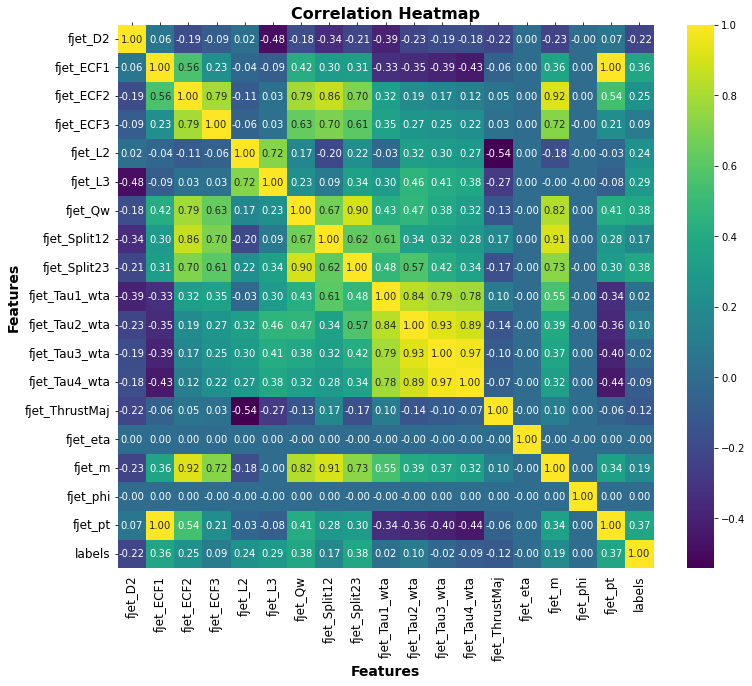

In [46]:
# Plotting a correlation heatmap
plot_correlation_heatmap(handy_df_filtered)

Some features demonstrate high positive correlation, e.g. ```fjet_m``` is very much correlated with ```fjet_ECF2``` and ```fjet_Split12, fjet_ECF1``` is very much correlated with ```fjet_pt```, and ```fjet_Qw``` is also very much correlated with ```fjet_Split23```. However, the ```labels``` fail to show a strong correlation with the features, possibly resulting from the large spread across features and the only two values on the labels.

<a class="anchor" id="1.7"></a>
### 1.7 Skewness

For further understanding of the data, let's examine the data distribution.

In [51]:
# Plot histograms for all columns in a dataset.
def plot_histograms(handy_df, num_bins=20, figsize=(12, 20)):
    # Get the list of column names from the Handy dataset
    columns = handy_df.columns

    # Calculate the number of rows and columns for subplots
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2  # Adjust for odd number of columns

    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)

    # Flatten axes if needed
    if num_rows == 1:
        axes = [axes]

    # Iterate over each column and plot the histogram
    for i, col in enumerate(columns):
        # Compute histogram
        bins, counts = handy_df.select(col).rdd.flatMap(lambda x: x).histogram(num_bins)
        
        # Plot histogram
        ax = axes[i // 2][i % 2]  # Select the appropriate axis
        ax.hist(bins[:-1], bins=bins, weights=counts)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

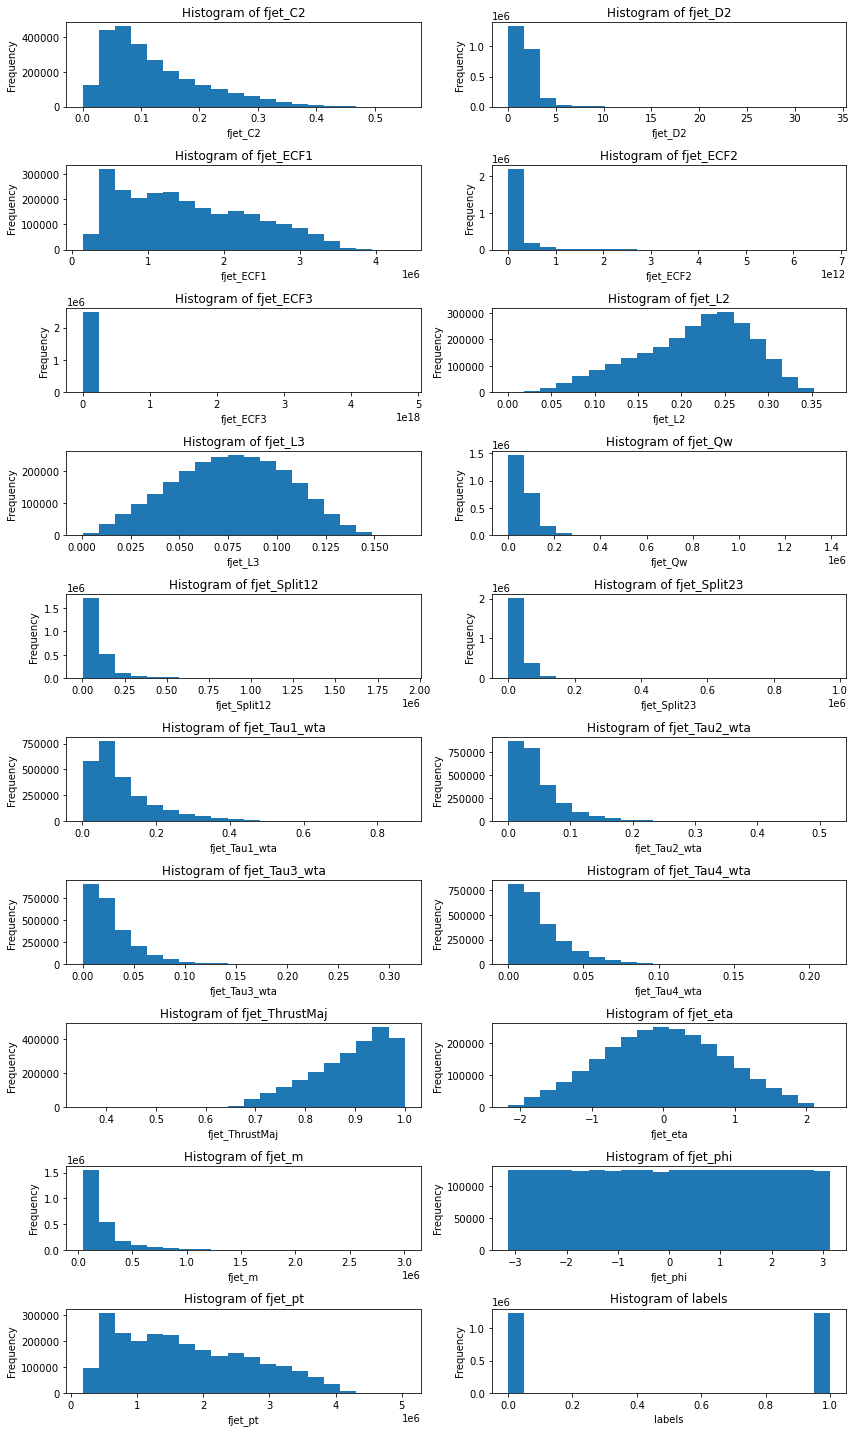

In [52]:
# Plotting histograms
plot_histograms(handy_df_filtered)

As seen from the histograms, most of the individual features exhibit skewness. Specifically, ```fjet_C2, fjet_D2, fjet_ECF1, fjet_ECF2, fjet_ECF3, fjet_Qw, fjet_Split12, fjet_Split23, fjet_Tau1_wta, fjet_Tau2_wta, fjet_Tau3_wta, fjet_Tau4_wta, fjet_m```, and ```fjet_pt``` have positive skewness, while ```fjet_ThrustMaj``` has negative skewness. Both positive and negative skewness may indicate the presence of outliers or anomalous values in the dataset.

The histograms of ```fjet_L2, fjet_L3, fjet_eta```, and ```fjet_phi``` show normal or nearly normal distributions.

<a class="anchor" id="1.8"></a>
### 1.8 Outliers

Calculating the number of outliers for each column

In [60]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, cols):
    outliers_count = 0
    total_rows = df.count()

    for col in cols:
        # Calculate the first and third quartiles and IQR
        q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
        iqr = q3 - q1

        # Define the lower and upper bounds for outliers detection
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Count the number of outliers in the current column
        outliers_count += df.filter((df[col] < lower_bound) | (df[col] > upper_bound)).count()

    # Calculate the percentage of rows with outliers
    outliers_percentage = outliers_count / total_rows * 100
    return outliers_count, outliers_percentage

# Define the list of columns
columns = handy_df_filtered.columns

# Detect outliers and calculate the percentage of rows with outliers
outliers_count, outliers_percentage = detect_outliers_iqr(handy_df_filtered, columns)
print("Total rows with outliers:", outliers_count)
print("Percentage of rows with outliers:", outliers_percentage)

Total rows with outliers: 2189541
Percentage of rows with outliers: 88.14162134875289


The percentage of rows with outliers is very high, however, it should be noted that this includes rows where at least one outlier is present in at least one column. Additionally, the previously presented histograms also indicate a high skewness of most of the data, which is confirmed by the calculated number of outliers. Let's investigate it further.

Temporarily disable the safety checks of the HandySpark DataFrame to remove limitations on processing a large amount of data for the following operations. Otherwise, only 1000 values from the instance will be processed.

In [6]:
# Disabling the safety checks for data visualization in HandySpark DataFrame
handy_df_filtered.safety_off()

HandyFrame[fjet_C2: double, fjet_D2: double, fjet_ECF1: double, fjet_ECF2: double, fjet_ECF3: double, fjet_L2: double, fjet_L3: double, fjet_Qw: double, fjet_Split12: double, fjet_Split23: double, fjet_Tau1_wta: double, fjet_Tau2_wta: double, fjet_Tau3_wta: double, fjet_Tau4_wta: double, fjet_ThrustMaj: double, fjet_eta: double, fjet_m: double, fjet_phi: double, fjet_pt: double, labels: double]

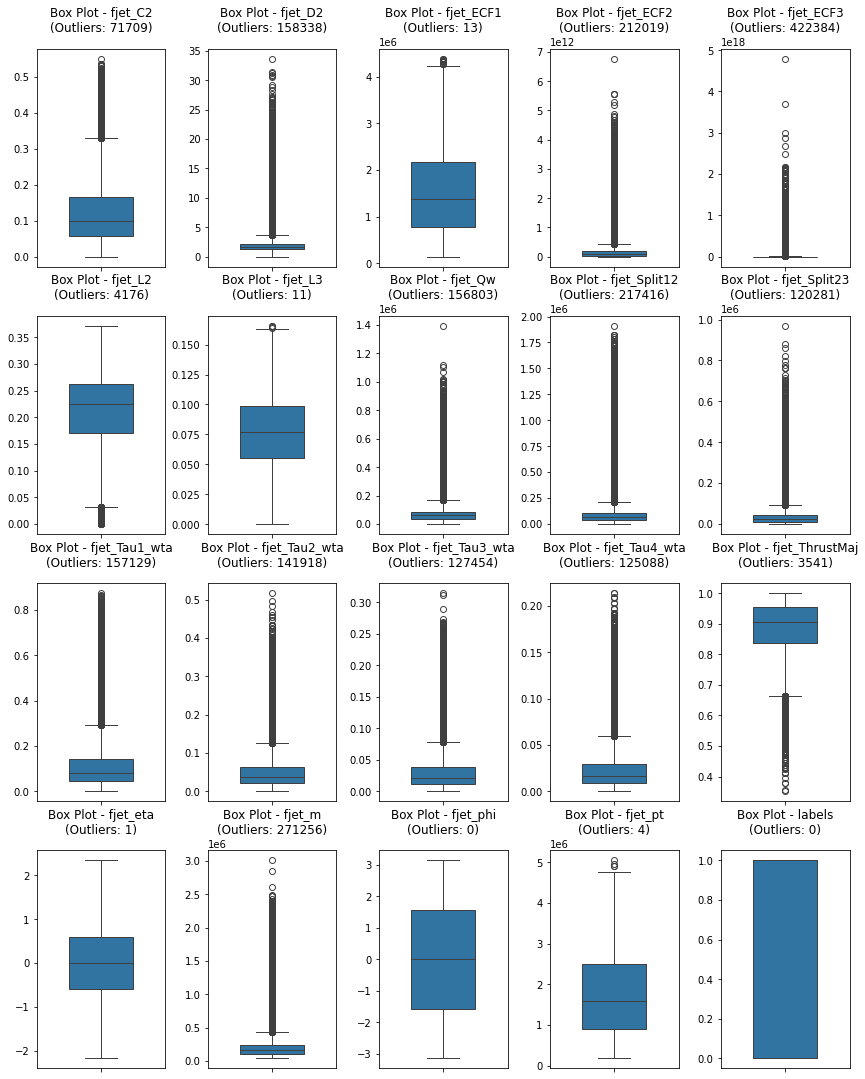

In [12]:
# Plot box plots for each column
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 15))

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=4.5)

# Get the column names of the DataFrame
columns = handy_df_filtered.columns

# Iterate over each column to create box plots
for i, col_name in enumerate(columns):
    # Calculate quartiles
    quantiles = handy_df_filtered.approxQuantile(col_name, [0.25, 0.75], 0.01)
    q1 = quantiles[0]
    q3 = quantiles[1]
    # Calculate interquartile range (IQR)
    iqr = q3 - q1
    # Define lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Filter DataFrame to find outliers
    outliers_df = handy_df_filtered.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
    
    # Extract data for the box plot
    data = handy_df_filtered.select(col_name).collect()
    data_values = [x[0] for x in data]
    
    # Plot box plot
    sns.boxplot(y=data_values, ax=axes[i // 5, i % 5], width=0.5)
    axes[i // 5, i % 5].set_title(f'Box Plot - {col_name}\n(Outliers: {outliers_df.count()})', y=1.05)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

As expected, datasets with noted skewness have a significantly higher number of outliers. Given that the dataframe includes various parameters conducted in real experiments, the identified outliers also hold practical value for pattern formation in top quark detection. Additionally, calculating the percentage of all cells with outliers (not rows) relative to the total number of data cells yields just below 6%. Therefore, this data will be preserved for further model construction.

The DataFrame is ready for Deep Learning.

## 2. Deep Learning

For binary classification, several types of neural networks can be applied. Within this research, I will consider two of them: SkiKit-Learn Multi-Layer Perceptron (MLP) Classifier and Keras Classifier.

Converting the HandySpark DataFrame to a Pandas DataFrame for working with neural networks.

In [7]:
# Converting the HandySpark DataFrame to a Pandas DataFrame
result_df = handy_df_filtered.toPandas()

<a class="anchor" id="2.1"></a>
### 2.1 SciKit-Learn MLP Classifier

In [8]:
# Extracting features (x) and labels (y)
x = np.array(result_df.iloc[:, :-1]) # Features
y = np.array(result_df.iloc[::,-1])  # Labels

In [9]:
# Check the shapes of the feature matrix (x) and the label vector (y)
x.shape, y.shape

((2484117, 19), (2484117,))

In [10]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Standardize the features using StandardScaler
standard_scaler = StandardScaler()

# Fit the scaler on training data and transform it
standard_scaled_x_train = standard_scaler.fit_transform(x_train)

# Transform the test data using the same scaler
standard_scaled_x_test = standard_scaler.transform(x_test)

In [11]:
# Initialize a MLP classifier
mlp_net = MLPClassifier()

# Train the MLP classifier on the standardized training data
mlp_net.fit(standard_scaled_x_train, y_train)

MLPClassifier()

In [12]:
# Use the trained MLP classifier to predict labels for the standardized test data
yhat_mlp_net = mlp_net.predict(standard_scaled_x_test)

# Generate a classification report for the MLP classifier's predictions on the test data
mlp_net_assessment = pd.DataFrame(metrics.classification_report(y_test, yhat_mlp_net, output_dict=True)).transpose()

# Display the classification report
mlp_net_assessment

,precision,recall,f1-score,support
0.0,0.890236,0.872008,0.881028,248288.000000
1.0,0.874698,0.892591,0.883554,248536.000000
accuracy,0.882304,0.882304,0.882304,0.882304
macro avg,0.882467,0.882299,0.882291,496824.000000
weighted avg,0.882463,0.882304,0.882291,496824.000000


Based on the classification report, the following conclusions can be made:

- A model outputs generally the same results with similar precision, recall and F1-scores for both the class 1.0 (positive) and the class 0.0 (negative).

- The precision, recall, and F1-score for both classes are above 0.85, the model runs well and working properly. Thus, it is capable of correctly identifying instances for both classes correctly.

- The model accuracy is 0.882, which means that 88.2% of predicted values by the model are correct.

- In general, the model was able to differentiate between correct classes and got good performance values for both classes.

Plotting the Receiver Operating Characteristic (ROC) curve and computing the Area Under the Curve (AUC) for the MLP classifier

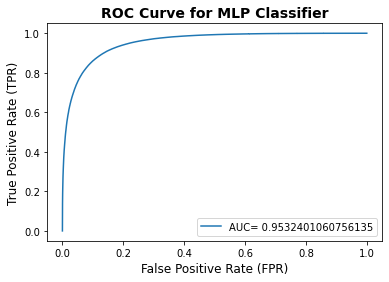

In [13]:
# Use the trained MLP classifier to predict probabilities for the positive class (label=1) 
# for the standardized test data
yhat_proba_mlp_net = mlp_net.predict_proba(standard_scaled_x_test)[::,1]

# Compute the false positive rate (FPR) and true positive rate (TPR) for different thresholds
# using the predicted probabilities and true labels of the test data
fpr_mlp_net, tprr_mlp_net, _ = metrics.roc_curve(y_test, yhat_proba_mlp_net)

# Compute the area under the ROC curve (AUC) using the predicted probabilities and true labels
area_under_curve_mlp_net = metrics.roc_auc_score(y_test, yhat_proba_mlp_net)

# Plot the ROC curve using FPR and TPR, and display the AUC in the legend
plt.plot(fpr_mlp_net, tprr_mlp_net, label = "AUC= " + str(area_under_curve_mlp_net))
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("ROC Curve for MLP Classifier", fontweight='bold', fontsize=14)
plt.legend(loc = "best")
plt.show()

An AUC (Area Under the Curve) of 0.95 indicates the model posses the capability to identify and classify the positive class with high accuracy. Generally, the model is able to place 95% of the randomly selected positive instance higher in the ranking than the randomly selected negative instance.

Calculating and plotting the precision-recall curve for the MLP classifier model.

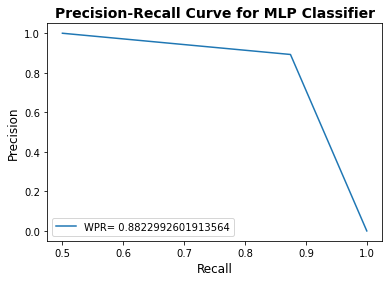

In [14]:
# Compute precision and recall values using the predicted probabilities 
# and true labels of the test data
p_mlp_net, r_mlp_net, _ = metrics.precision_recall_curve(y_test, yhat_mlp_net)

# Compute the weighted precision score using the predicted probabilities and true labels
weighted_ps_mlp_net = metrics.roc_auc_score(y_test, yhat_mlp_net)

# Plot the precision-recall curve using recall and precision values
plt.plot(p_mlp_net, r_mlp_net,label = "WPR= " + str(weighted_ps_mlp_net))
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve for MLP Classifier", fontweight='bold', fontsize=14)
plt.legend(loc = "best")
plt.show()

The Weighted Recall Precision (WRP) score of 0.88 depicts that the model performs a well-balanced task in terms of both precision and recall. In such case, model is able to make the right balance between the number of true positive predictions (precision) and the proportion of correctly identified actual positive instances (recall).

<a class="anchor" id="2.2"></a>
### 2.2 Keras Classifier

In [16]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=0)

# Initialize a StandardScaler to standardize the features
standard_scaler = StandardScaler()
# Standardize the training and testing features using the StandardScaler
standard_scaled_x_train = standard_scaler.fit_transform(x_train)
standard_scaled_x_test = standard_scaler.transform(x_test)

In [17]:
# Convert the standardized training features to a numpy array
standard_scaled_x_train = np.array([np.array(val) for val in standard_scaled_x_train])

In [18]:
# Function to create a Keras classifier neural network model
def keras_classifier_net(optimizer="adam"):
    # Initialize the Keras Sequential model
    keras_classifier_net_model = Sequential()
    # Add the input layer with 64 neurons, using ReLU activation function, and regularizers
    keras_classifier_net_model.add(Dense(64, input_dim=19, activation="relu",kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.01)))
    # Add a hidden layer with 32 neurons and ReLU activation function
    keras_classifier_net_model.add(Dense(32, activation="relu"))
    # Add the output layer with 1 neuron and Sigmoid activation function
    keras_classifier_net_model.add(Dense(1, activation="sigmoid"))
    # Compile the model with binary cross-entropy loss function, chosen optimizer, and accuracy metric
    keras_classifier_net_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return keras_classifier_net_model

In [19]:
# Create a KerasClassifier object using the defined keras_classifier_net function as the build function
keras_classifier_net_model = KerasClassifier(build_fn=keras_classifier_net)

In [22]:
# Train the KerasClassifier model on the standardized training data
keras_classifier_net_model_history = keras_classifier_net_model.fit(standard_scaled_x_train, y_train, batch_size=14, epochs=10)
# Display the history of the training process
keras_classifier_net_model_history

Epoch 1/10
113560/113560 [==============================] - 63s 551us/step - loss: 0.3273 - accuracy: 0.8695
Epoch 2/10
113560/113560 [==============================] - 53s 469us/step - loss: 0.3155 - accuracy: 0.8730
Epoch 3/10
113560/113560 [==============================] - 53s 469us/step - loss: 0.3140 - accuracy: 0.8735
Epoch 4/10
113560/113560 [==============================] - 52s 459us/step - loss: 0.3130 - accuracy: 0.8738
Epoch 5/10
113560/113560 [==============================] - 52s 462us/step - loss: 0.3125 - accuracy: 0.8741
Epoch 6/10
113560/113560 [==============================] - 53s 469us/step - loss: 0.3123 - accuracy: 0.8741
Epoch 7/10
113560/113560 [==============================] - 53s 471us/step - loss: 0.3121 - accuracy: 0.8744
Epoch 8/10
113560/113560 [==============================] - 53s 465us/step - loss: 0.3119 - accuracy: 0.8742
Epoch 9/10
113560/113560 [==============================] - 65s 575us/step - loss: 0.3118 - accuracy: 0.8742
Epoch 10/10
113560/

<a class="anchor" id="2.2.1"></a>
#### 2.2.1 Model Evaluation

In [23]:
# Use the trained Keras  classifier to predict labels for the standardized test data
keras_yhat_classifier_net = keras_classifier_net_model.predict(standard_scaled_x_test)

# Generate a classification report for the predictions made by the Keras Classifier
keras_classifier_net_model_results = pd.DataFrame(metrics.classification_report(y_test, keras_yhat_classifier_net,
                                                                                output_dict=True)).transpose()
# Display the classification report
keras_classifier_net_model_results

15526/15526 [==============================] - 5s 326us/step


,precision,recall,f1-score,support
0.0,0.878732,0.870078,0.874384,248288.000000
1.0,0.871472,0.880046,0.875738,248536.000000
accuracy,0.875064,0.875064,0.875064,0.875064
macro avg,0.875102,0.875062,0.875061,496824.000000
weighted avg,0.875100,0.875064,0.875061,496824.000000


Based on the classification report, the following conclusions can be made:
- The model performs with similar precision and recall for both the positive class (labeled 1.0) and the negative class (labeled 0.0).

- The model has the precision and recall of above 0.87 for both classes, which suggests that the model performs well in classifying.

- The overall expectation precision of model is 0.875, implied that the number of correct predictions is 87.5% by the model.

- In general, the model was able to differentiate between correct classes and got good performance values for both classes.

In [24]:
# Use the trained Keras classifier to predict labels for the standardized test data
predictions = keras_classifier_net_model.predict(standard_scaled_x_test)

15526/15526 [==============================] - 5s 325us/step


In [25]:
# Round the predicted probabilities to the nearest integer
rounded = [int(np.round(x, 0)) for x in predictions]

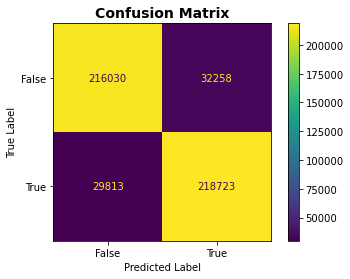

In [43]:
# Get the actual and predicted labels
actual = y_test
predicted = rounded

# Compute the confusion matrix
confusion_matrix = metrics.confusion_matrix(actual, predicted)

# Create a ConfusionMatrixDisplay object with the confusion matrix and display labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# Plot the confusion matrix

cm_display.plot(cmap='viridis', values_format='g')
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()

Based on the confusion matrix:
- The model proves its ability to accurately predict true negatives, the amount counts as 216,030.
- The model has 32,258 examples of false-positive pitfalls, where it wrongly predicts negative cases as positive.
- The model provides a close fit for the true positive cases with a count of 218,723.
- Model has false positive rate of 29,813, where it wrongly predicts positive cases as negative.
- Generally, the model is evenly good at predicting both positive and negative cases with the slight increase in the frequency of false positives from the false negatives.

In [27]:
# Print the first 5 predicted and expected values
for i in range(5):
        print(str(rounded[i]) + '=>(expected '+ str(y_test[i]) +')')

1=>(expected 1.0)
0=>(expected 0.0)
1=>(expected 1.0)
1=>(expected 0.0)
1=>(expected 1.0)


<a class="anchor" id="2.2.2"></a>
#### 2.2.2 Hyperparameter tuning

In [23]:
# Function to create a Keras model with specified optimizer, loss function, learning and regularization rates
def create_model(optimizer='adam', loss='binary_crossentropy', learning_rate=0.001, l1_rate=0.001, l2_rate=0.001):
    # Configure the optimizer based on the input parameter
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
        
    # Create a Sequential model
    model = Sequential()
    # Add a dense layer with ReLU activation and L1-L2 regularization
    model.add(Dense(64, input_dim=19, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_rate, l2=l2_rate)))
    # Add another dense layer with ReLU activation and L1-L2 regularization
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_rate, l2=l2_rate)))
    # Add the output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model with specified loss function, optimizer, and evaluation metric
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

# Create a KerasClassifier model
keras_model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'loss': ['binary_crossentropy', 'mean_squared_error'],
    'learning_rate': [0.001, 0.01, 0.1],
    'l1_rate': [0.001, 0.01],
    'l2_rate': [0.001, 0.01]  
}

# I decided to use RandomizedSearchCV because it is much faster than GridSearchCV when 
# dealing with a large data set. GridSearchCV implements an exhaustive search that 
# evaluates all possible combinations of hyperparameters, which can be very expensive 
# in terms of computing and time consuming, especially on a large dataset. On the contrary, 
# RandomizedSearchCV samples a certain number of random combinations of hyperparameters 
# from the provided distributions that provides more exploration of search space at a 
# faster rate.

# Define RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=keras_model,  # KerasClassifier model to use
                                   param_distributions=param_dist,  # Dictionary with parameters
                                   n_iter=10,  # Number of iterations
                                   cv=3,  # Cross-validation - dataset will be split into 3 folds
                                   verbose=1)  # Verbosity level

# Define early stopping criteria using EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss',  # Metric to monitor for early stopping
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of monitored metric

# Perform hyperparameter tuning with early stopping
random_result = random_search.fit(standard_scaled_x_train, 
                                  y_train, 
                                  batch_size=14,  # Number of samples per gradient update
                                  epochs=30,  # Number of epochs to train the model
                                  callbacks=[early_stopping])  # List of callbacks to apply during training

# Print the results of hyperparameter tuning
print("Best accuracy: %.4f using %s" % (random_result.best_score_, random_result.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/30
75707/75707 [==============================] - 32s 423us/step - loss: 0.5396 - accuracy: 0.8093
Epoch 2/30
75707/75707 [==============================] - 31s 410us/step - loss: 0.4783 - accuracy: 0.8117
Epoch 3/30
75707/75707 [==============================] - 31s 415us/step - loss: 0.4759 - accuracy: 0.8110
Epoch 4/30
75707/75707 [==============================] - 33s 432us/step - loss: 0.4746 - accuracy: 0.8112
Epoch 5/30
75707/75707 [==============================] - 33s 432us/step - loss: 0.4739 - accuracy: 0.8108
Epoch 6/30
75707/75707 [==============================] - 32s 427us/step - loss: 0.4732 - accuracy: 0.8107
Epoch 7/30
75707/75707 [==============================] - 32s 424us/step - loss: 0.4724 - accuracy: 0.8106
Epoch 8/30
75707/75707 [==============================] - 33s 431us/step - loss: 0.4723 - accuracy: 0.8105
Epoch 9/30
75707/75707 [==============================] - 33s 436us/step - loss: 0.

75707/75707 [==============================] - 35s 459us/step - loss: 0.1652 - accuracy: 0.8097
Epoch 11/30
75707/75707 [==============================] - 37s 484us/step - loss: 0.1649 - accuracy: 0.8099
Epoch 12/30
75707/75707 [==============================] - 34s 451us/step - loss: 0.1647 - accuracy: 0.8092
Epoch 13/30
75707/75707 [==============================] - 40s 532us/step - loss: 0.1644 - accuracy: 0.8094
Epoch 14/30
75707/75707 [==============================] - 41s 548us/step - loss: 0.1643 - accuracy: 0.8093
Epoch 15/30
75707/75707 [==============================] - 53s 700us/step - loss: 0.1641 - accuracy: 0.8095
Epoch 16/30
75707/75707 [==============================] - 46s 608us/step - loss: 0.1640 - accuracy: 0.8094
Epoch 17/30
75707/75707 [==============================] - 43s 574us/step - loss: 0.1638 - accuracy: 0.8091
Epoch 18/30
75707/75707 [==============================] - 50s 656us/step - loss: 0.1637 - accuracy: 0.8090
Epoch 19/30
75707/75707 [===============

Epoch 7/30
75707/75707 [==============================] - 41s 542us/step - loss: 0.4015 - accuracy: 0.8465
Epoch 8/30
75707/75707 [==============================] - 45s 590us/step - loss: 0.4012 - accuracy: 0.8462
Epoch 9/30
75707/75707 [==============================] - 45s 596us/step - loss: 0.4006 - accuracy: 0.8463
Epoch 10/30
75707/75707 [==============================] - 43s 565us/step - loss: 0.3999 - accuracy: 0.8466
Epoch 11/30
75707/75707 [==============================] - 40s 523us/step - loss: 0.3996 - accuracy: 0.8467
Epoch 12/30
75707/75707 [==============================] - 39s 517us/step - loss: 0.3989 - accuracy: 0.8466
Epoch 13/30
75707/75707 [==============================] - 39s 509us/step - loss: 0.3987 - accuracy: 0.8465
Epoch 14/30
75707/75707 [==============================] - 39s 520us/step - loss: 0.3984 - accuracy: 0.8466
Epoch 15/30
75707/75707 [==============================] - 40s 528us/step - loss: 0.3984 - accuracy: 0.8464
Epoch 16/30
75707/75707 [======

75707/75707 [==============================] - 32s 429us/step - loss: 0.1132 - accuracy: 0.8648
Epoch 5/30
75707/75707 [==============================] - 34s 450us/step - loss: 0.1124 - accuracy: 0.8649
Epoch 6/30
75707/75707 [==============================] - 34s 444us/step - loss: 0.1118 - accuracy: 0.8649
Epoch 7/30
75707/75707 [==============================] - 34s 449us/step - loss: 0.1114 - accuracy: 0.8650
Epoch 8/30
75707/75707 [==============================] - 33s 440us/step - loss: 0.1111 - accuracy: 0.8649
Epoch 9/30
75707/75707 [==============================] - 33s 430us/step - loss: 0.1109 - accuracy: 0.8646
Epoch 10/30
75707/75707 [==============================] - 34s 451us/step - loss: 0.1107 - accuracy: 0.8648
Epoch 11/30
75707/75707 [==============================] - 34s 443us/step - loss: 0.1105 - accuracy: 0.8646
Epoch 12/30
75707/75707 [==============================] - 34s 443us/step - loss: 0.1104 - accuracy: 0.8645
Epoch 13/30
75707/75707 [====================

75707/75707 [==============================] - 38s 508us/step - loss: 0.1108 - accuracy: 0.8621
Epoch 20/30
75707/75707 [==============================] - 38s 502us/step - loss: 0.1108 - accuracy: 0.8621
Epoch 21/30
75707/75707 [==============================] - 39s 509us/step - loss: 0.1108 - accuracy: 0.8619
Epoch 22/30
75707/75707 [==============================] - 35s 459us/step - loss: 0.1107 - accuracy: 0.8621
Epoch 23/30
75707/75707 [==============================] - 40s 534us/step - loss: 0.1107 - accuracy: 0.8620
Epoch 24/30
75707/75707 [==============================] - 34s 452us/step - loss: 0.1106 - accuracy: 0.8620
Epoch 25/30
75707/75707 [==============================] - 36s 482us/step - loss: 0.1106 - accuracy: 0.8620
Epoch 26/30
75707/75707 [==============================] - 36s 477us/step - loss: 0.1106 - accuracy: 0.8621
Epoch 27/30
75707/75707 [==============================] - 35s 465us/step - loss: 0.1105 - accuracy: 0.8619
Epoch 28/30
75707/75707 [===============

2024-04-05 22:38:35.789906: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 120827384 exceeds 10% of free system memory.


113560/113560 [==============================] - 56s 493us/step - loss: 0.3839 - accuracy: 0.8629
Epoch 2/30
113560/113560 [==============================] - 55s 482us/step - loss: 0.3403 - accuracy: 0.8661
Epoch 3/30
113560/113560 [==============================] - 55s 480us/step - loss: 0.3379 - accuracy: 0.8659
Epoch 4/30
113560/113560 [==============================] - 53s 471us/step - loss: 0.3375 - accuracy: 0.8657
Epoch 5/30
113560/113560 [==============================] - 54s 478us/step - loss: 0.3373 - accuracy: 0.8659
Epoch 6/30
113560/113560 [==============================] - 53s 469us/step - loss: 0.3372 - accuracy: 0.8655
Epoch 7/30
113560/113560 [==============================] - 55s 482us/step - loss: 0.3372 - accuracy: 0.8656
Epoch 8/30
113560/113560 [==============================] - 54s 478us/step - loss: 0.3372 - accuracy: 0.8654
Epoch 9/30
113560/113560 [==============================] - 54s 475us/step - loss: 0.3371 - accuracy: 0.8656
Epoch 10/30
113560/113560 [===

In [24]:
# Save the best performing model to a file
best_model = random_result.best_estimator_
best_model.model.save('best_model.h5')

In [30]:
# Evaluate the best model on the test set
test_accuracy = best_model.score(standard_scaled_x_test, y_test, verbose=0)
print("Accuracy on test set: {:.4f}".format(test_accuracy))

Accuracy on test set: 0.8608


In [32]:
# Stop the SparkSession
spark.stop()